# ADAM _ A Method for Stochastic Optimization

## 0. Paper

### Info
* TItle : ADAM _ A Method for Stochastic Optimization
* Author : Diederik P. Kingma, Jimmy Lei Ba
* Link : https://arxiv.org/pdf/1412.6980.pdf

### Summary
* first, second moment를 사용해 parameter별 adaptive learning rate 적용
* AdaGrad와 RMSProp의 장점을 조합함

### Differences
* ##

## 1. Setting

In [ ]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

In [ ]:
# Hyperparameters
CONFIG = {
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
    'batch_size' : 128,
    'epoch_size' : 30
}

## 2. Data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

## 3. Model

In [ ]:
class AdamOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=1e-3, beta1=0.9, beta2=0.999, name='AdamOptimizer', **kwargs):
        super(AdamOptimizer, self).__init__(name, **kwargs)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = 1e-7
    
    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')

    @tf.function
    def _resource_apply_dense(self, grad, var):
        var_dtype = var.dtype.base_dtype
        local_step = tf.cast(self.iterations + 1, var_dtype)

        m = self.get_slot(var, 'm')
        v = self.get_slot(var, 'v')
        
        new_m = self.beta1 * m + (1-self.beta1) * grad
        new_v = self.beta2 * v + (1-self.beta2) * grad * grad        
        new_m_hat = new_m / (1 - tf.math.pow(self.beta1, local_step))
        new_v_hat = new_v / (1 - tf.math.pow(self.beta2, local_step))
        
        new_var = var - self.learning_rate * new_m_hat / (tf.math.sqrt(new_v_hat) + self.epsilon)
        var.assign(new_var)
        m.assign(new_m)
        v.assign(new_v)
    
    @tf.function
    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        config = super().get_config()
        config.update({
            'learning_rate' : self.learning_rate,
            'beta1' : self.beta1,
            'beta2' : self.beta2
        })

        return config

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, 5, activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, 5, activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, 5, activation='relu')
        self.pool = tf.keras.layers.MaxPool2D(3, strides=2)
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1000, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation='softmax')
    
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

## 4. Train

In [ ]:
sgd = tf.keras.optimizers.SGD()
sgd_model = Model()
sgd_model.compile(
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc'],
    optimizer = 'sgd'
)

In [ ]:
sgd_history = sgd_model.fit(x_train, y_train, batch_size=CONFIG['batch_size'], epochs=CONFIG['epoch_size'])

In [ ]:
default_adam = tf.keras.optimizers.Adam()
default_model = Model()
default_model.compile(
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc'],
    optimizer = default_adam
)

In [ ]:
default_history = default_model.fit(x_train, y_train, batch_size=CONFIG['batch_size'], epochs=CONFIG['epoch_size'])

In [ ]:
custom_adam = AdamOptimizer()
custom_model = Model()
custom_model.compile(
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc'],
    optimizer = custom_adam
)

In [ ]:
custom_history = custom_model.fit(x_train, y_train, batch_size=CONFIG['batch_size'], epochs=CONFIG['epoch_size'])

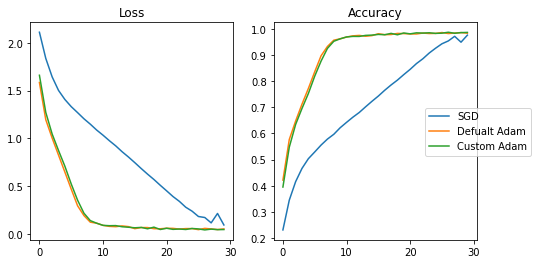

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].plot(sgd_history.history['loss'])
ax[0].plot(default_history.history['loss'])
ax[0].plot(custom_history.history['loss'])
ax[0].set_title('Loss')

ax[1].plot(sgd_history.history['acc'])
ax[1].plot(default_history.history['acc'])
ax[1].plot(custom_history.history['acc'])
ax[1].set_title('Accuracy')

fig.legend(['SGD', 'Defualt Adam', 'Custom Adam'], loc='right')
plt.show()